In [16]:
from fbm import FBM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.animation import FuncAnimation
from IPython import display
from statsmodels.graphics.tsaplots import plot_acf

In [17]:
import importlib
import muravlev_approximation
importlib.reload(muravlev_approximation)
from muravlev_approximation import fbm_muravlev
from hurst_estimation import m_estimator, w_estimator

## Muravlev's method for fBM simulation

Let $\xi=(\xi_\beta)_{\beta>0}$ be a Gaussian process with zero mean and covariance function
$$
\mathrm{cov}(\xi_\alpha, \xi_\beta) = \frac{1}{\alpha+\beta}, \qquad \alpha,\beta>0.
$$

Let $B_t$ be a Brownian motion independent of $\xi$. Define the family of Ornstein-Uhlenbeck processes $Z^\beta = (Z_t^\beta)_{t\ge 0}$ driven by the same Brownian motion $B_t$:
$$
d Z_t^\beta = -\beta Z_t^\beta dt + d B_t, \qquad Z_0^\beta = \xi_\beta.
$$

Then for $H\in(0,\frac12)$ we have the following representation:
$$
B_t^H = c_H \int_0^\infty \beta^{-1/2-H} (Z_t^\beta - \xi_\beta) d \beta,
$$
where $c_H$ is some constant.

In [146]:
# Parameters
n = 4096
H = 0.1

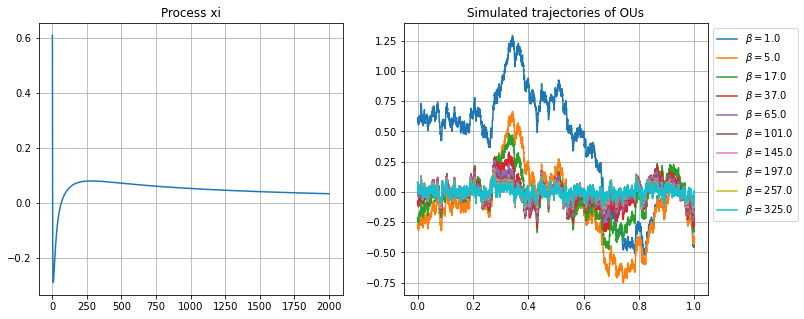

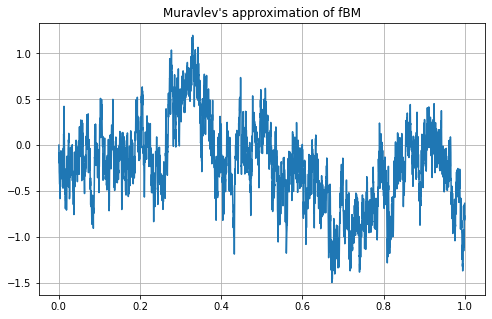

In [147]:
# Muravlev's approximation
muravlev_fbm, Z = fbm_muravlev(n=n, hurst=H, n_beta=2000, beta_max=2000, uniform_beta_grid=True, plotting=True, extended_return=True)

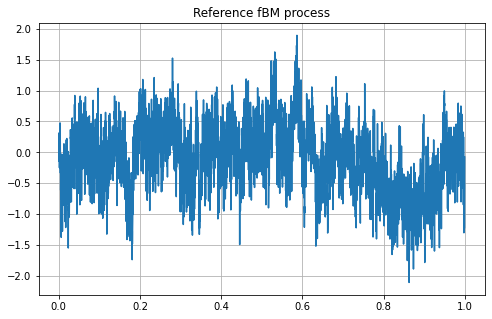

In [148]:
# Reference fBM
time_grid = np.linspace(0, 1, n+1)
ref_fbm = FBM(n=n, hurst=H, length=1, method='daviesharte').fbm()

_, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_grid, ref_fbm)
ax.set_title("Reference fBM process")
ax.grid()

In [149]:
# Hurst parameters
m_estimator(ref_fbm), m_estimator(muravlev_fbm)

(0.10356843288732376, 0.26406628780074404)

## Observations

**Uniform $\beta$-grid**

1. The results significantly depend on the truncation value *beta_max* of beta given *n_beta* fixed. Rough processes need greater value of *beta_max*, for the processes with $H \approx 0.4$ the intergral converges faster and the integrand varies more, so in this case more accurate grid around zero is needed.
2. The most time-consuming part of simulation is a simulation of the process $\xi_\beta$ for large values of *n_beta*. This problem can be solved by using non-uniform grid of change of the variables in the integral.
3. For very large values of $\beta$, when $\beta \Delta t > 2$, numerical problems occur in OU simulation.
4. Computation time depends mostly on the size of covariance matrix of $\xi_\beta$ rather than the time grid size.

## Modification of standard Muravlev's approximation

### Problem of straightforward approximation:
The integral $\int_0^\infty \beta^{-1/2-H} (Z_t^\beta - \xi_\beta) d \beta$ converges slowly for small values of $H$.

**Lemma 1** For any $t > 0$
$$
\mathbb{E}Z_t^{\beta_1}Z_t^{\beta_2} = \dfrac{1}{\beta_1 + \beta_2}, 
\quad \mathbb{E}(Z_t^{\beta_1} - \xi_{\beta_1})(Z_t^{\beta_2} - \xi_{\beta_2}) = \dfrac{2 - e^{-\beta_1 t} - e^{-\beta_2 t}}{\beta_1 + \beta_2}, \\
\mathrm{Corr}(\xi_{\beta_1}, \xi_{\beta_2}) = \dfrac{2\sqrt{\beta_1\beta_2}}{\beta_1 + \beta_2}, \quad \mathrm{Corr}(Z_t^{\beta_1} - \xi_{\beta_1}, Z_t^{\beta_1} - \xi_{\beta_2}) = \dfrac{\sqrt{\beta_1\beta_2}}{\beta_1 + \beta_2}\dfrac{2 - e^{-\beta_1t} - e^{-\beta_2t}}{\sqrt{1 - e^{-\beta_1 t}}\sqrt{1 - e^{-\beta_2 t}}}.
$$

Thus, the processes $\xi_\beta$ and $Z_t^{\beta_2} - \xi_{\beta_2}$ varies slower as $\beta \to \infty$:
$$
\mathrm{Corr}(\xi_{\beta}, \xi_{\beta + \delta}) = \dfrac{\sqrt{1 + \frac{\delta}{\beta}}}{1 + \frac{\delta}{2\beta}} \underset{\beta\to\infty}{\longrightarrow} 1
$$

Moreover, the processes are $L^2$-differentiable since their covariance functions are twice differentiable for any $\beta_1, \beta_2 > 0$. 

### Estimation of the remainder

For the approximation we truncate the integral at the value $\beta^*$. The remainder is then
$$
\Psi_t(\beta^*) = c_H\int_{\beta^*}^\infty \beta^{-1/2-H} (Z_t^\beta - \xi_\beta) d \beta.
$$

**Statement 1** 
$$
    \mathbb{E} \Psi_t(\beta^*) = 0, \quad \sqrt{\mathrm{Var}\,\Psi_t(\beta^*)} \leq \dfrac{\Gamma\left(\frac12 - H\right)}{\sqrt{H\Gamma(1 - 2H)}}\dfrac{c_H}{(2\beta^*)^H}
$$
*Proof*
$$
\mathrm{Var}\,\Psi_t(\beta^*) = c_H^2\int_{\beta^*}^\infty \int_{\beta^*}^\infty \mathbb{E}\left[(\beta_1\beta_2)^{-\frac12 - H}(Z_t^{\beta_1} - \xi_{\beta_1})(Z_t^{\beta_2} - \xi_{\beta_2})\right]\,d\beta_1d\beta_2 = \\
=c_H^2\int_{\beta^*}^\infty \int_{\beta^*}^\infty \left[\dfrac{(\beta_1\beta_2)^{-\frac12 - H}}{\beta_1 + \beta_2}(2 - e^{-\beta_1 t} - e^{-\beta_2 t})\right]\,d\beta_1d\beta_2 \leq 2 c_H^2(1 - e^{-\beta^*t}) \int_{\beta^*}^\infty \int_{\beta^*}^\infty \dfrac{(\beta_1\beta_2)^{-\frac12 - H}}{\beta_1 + \beta_2}\,d\beta_1d\beta_2.
$$ 
To bound the last integral we change the variables $\beta = \beta_1,\ \gamma = \beta_1 + \beta_2$:
$$
\int_{\beta^*}^\infty \dfrac{(\beta_1\beta_2)^{-\frac12 - H}}{\beta_1 + \beta_2}\,d\beta_1d\beta_2 = 
\int_{2\beta^*}^\infty d\gamma \int_{\beta^*}^{\gamma - \beta^*} \beta^{-H-\frac12}(\gamma - \beta)^{-H - \frac12} d\beta \leq \\
\int_{2\beta^*}^\infty d\gamma \int_0^\gamma \beta^{-H-\frac12}(\gamma - \beta)^{-H - \frac12} d\beta =
B\left(\frac12 - H, \frac12 - H\right)\int_{2\beta^*}^\infty \gamma^{-2H - 1}d\gamma =
\dfrac{(2\beta^*)^{-2H}}{2H}\dfrac{\Gamma\left(\frac12 - H\right)^2}{\Gamma(1 - 2H)}
$$
Together with the previous estimation of variance we obtain the upper bound.

For $H = 0.1$ and $\beta^* = 10^4$ the value of
$\dfrac{\Gamma\left(\frac12 - H\right)}{\sqrt{H\Gamma(1 - 2H)}}\dfrac{c_H}{(2\beta^*)^H} \approx 0.4$.

### Change of the variable and Gauss-Jacobi quadrature
$$
\int_0^\infty \beta^{-1/2-H} (Z_t^\beta - \xi_\beta) d \beta = \left\{\beta = \dfrac{1 + \alpha}{1 - \alpha}\right\} =
2\int_{-1}^1\left(\dfrac{1 + \alpha}{1 - \alpha}\right)^{-1/2-H}\left(Z_t^{\frac{1 + \alpha}{1 - \alpha}} - \xi_{\frac{1 + \alpha}{1 - \alpha}}\right)\dfrac{d\alpha}{(1 - \alpha)^2} = \\
= 2\int_{-1}^1(1 - \alpha)^{H - \frac32}(1+\alpha)^{-H-\frac12}\left(Z_t^{\frac{1 + \alpha}{1 - \alpha}} - \xi_{\frac{1 + \alpha}{1 - \alpha}}\right)d\alpha.
$$

Problem with $(1 - \alpha)$: $H - \frac32 < -1$.
The variance
$$
\mathrm{Var}\left[Z_t^{\frac{1 + \alpha}{1 - \alpha}} - \xi_{\frac{1 + \alpha}{1 - \alpha}}\right] = \left(1 - \exp\left\{-\dfrac{1+\alpha}{1-\alpha}t\right\}\right)\dfrac{1 - \alpha}{1 + \alpha}
$$
is of order $\frac{1-\alpha}{1 + \alpha}$ for $\alpha \to 1$ and of order $\sqrt{t}$ for $\alpha \to -1$.

Hence, we can divide this process by $\sqrt{1 - \alpha}$ and obtain the integral for which Gaussian-Jacobi quadrature is applicable:
$$
2\int_{-1}^1(1 - \alpha)^{H - 1}(1+\alpha)^{-H-\frac12}Y_t^\alpha d\alpha \approx \sum_{i} w_i Y_t^{\alpha_i},
$$
where $Y_t^\alpha = \dfrac{1}{\sqrt{1 - \alpha}}\left(Z_t^{\frac{1 + \alpha}{1 - \alpha}} - \xi_{\frac{1 + \alpha}{1 - \alpha}}\right)$.

### Simulation of $Y_t^\alpha$

- Simulation of $Z_t^{\frac{1 + \alpha}{1 - \alpha}}$ and $\xi_{\frac{1 + \alpha}{1 - \alpha}}$ is numerically unstable for $\alpha \approx 1$.

Note that $Y_t^\alpha$ satisfy the following SDE w.r.t. $t$:
$$
dY_t^{\alpha} = -\dfrac{1+\alpha}{1-\alpha}(Y_t^\alpha + \eta_\alpha)dt + \dfrac{1}{\sqrt{1-\alpha}}dW_t,
$$
where $\eta_\alpha = \dfrac{\xi_{\frac{1+\alpha}{1-\alpha}}}{\sqrt{1 - \alpha}}$. Its covariance function is
$
\mathrm{Cov}(\eta_{\alpha_1}, \eta_{\alpha_2}) = \dfrac{\sqrt{1 - \alpha_1}\sqrt{1 - \alpha_2}}{2(1 - \alpha_1\alpha_2)}.
$

- Simulation of $Y_t^\alpha$ may be difficult for $\alpha \approx 1$ as the volatility it this case blows up.

However, exact simulation is possible since (we denote $\beta = \frac{1+\alpha}{1-\alpha}$):
$$
Y_{t + \Delta t}^\alpha = e^{-\beta \Delta t} Y_t^\alpha - (1 - e^{-\beta \Delta t})\eta_\alpha + \dfrac{1}{\sqrt{1 - \alpha}}\int_0^{\Delta t}e^{-\beta(\Delta t- s)}dW_s
$$
The variance of the stochastic integral
$$
\mathrm{Var}\left[\dfrac{1}{\sqrt{1 - \alpha}}\int_0^{\Delta t}e^{-\beta(\Delta t- s)}dW_s\right] = \dfrac{1}{2\beta(1-\alpha)}(1 - e^{-2\beta \Delta t}) = \dfrac{1 - e^{-2\beta \Delta t}}{2(1 + \alpha)}
$$
Hence, conditionally on $\eta_\alpha$ and $Y_t^\alpha$
$$
Y_{t + \Delta t}^\alpha \sim \mathcal{N}\left(e^{-\beta \Delta t} Y_t^\alpha - (1 - e^{-\beta \Delta t})\eta_\alpha, \dfrac{1 - e^{-2\beta \Delta t}}{2(1 + \alpha)}\right),
$$
and
$$
\mathrm{Cov}\left[Y_{t + \Delta t}^{\alpha_1}, Y_{t + \Delta t}^{\alpha_2}\right] =
\dfrac{1}{\sqrt{1 - \alpha_1}\sqrt{1 - \alpha_2}}\dfrac{1 - e^{-(\beta_1 + \beta_2)\Delta t}}{\beta_1 + \beta_2}.
$$

#### Simulation algorithm
1. Calculate points $\{\alpha_i\}$ and weights $\{w_i\}$ for the Gauss-Jacobi quadrature.
2. Simulate the process $\eta_\alpha$ on $\{\alpha_i\}$ via covariance function.
3. For each $t_j = j \Delta t$ simulate $Y_{t_j}^{\alpha_i}$ as a multivariate Gaussian using the exact simulation formula.
4. Estimate the integral by the quadrature and obtain 
$
B_{t_j}^H = 2c_H \sum_{i} w_i Y_{t_j}^{\alpha_i}.
$

In [150]:
n = 4096
n_beta = 20
hursts = [0.4, 0.3, 0.2, 0.1]

col_approx = "#E1829B"
col_ref = "#5F468D"

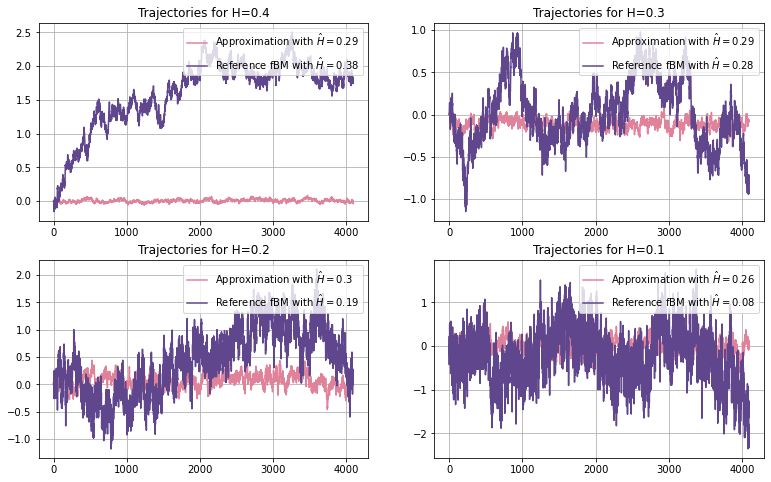

In [151]:
_, ax = plt.subplots(2, 2, figsize=(13, 8))

for num, hurst in enumerate(hursts):
    i, j = num // 2, num % 2
    muravlev_fbm_st = fbm_muravlev(n=n, hurst=hurst, mode='standard', n_beta=20, beta_max=1000, extended_return=False)
    ref_fbm = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    
    label_mur = r"Approximation with $\hat H = $" + str(np.round(m_estimator(muravlev_fbm_st), 2))
    label_ref = r"Reference fBM with $\hat H = $" + str(np.round(m_estimator(ref_fbm), 2))
    ax[i, j].plot(muravlev_fbm_st, label=label_mur, c=col_approx)
    ax[i, j].plot(ref_fbm, label=label_ref, c=col_ref)
    ax[i, j].set_title(f"Trajectories for H={hurst}")
    ax[i, j].grid()
    ax[i, j].legend(bbox_to_anchor=(1, 1), loc="upper right")

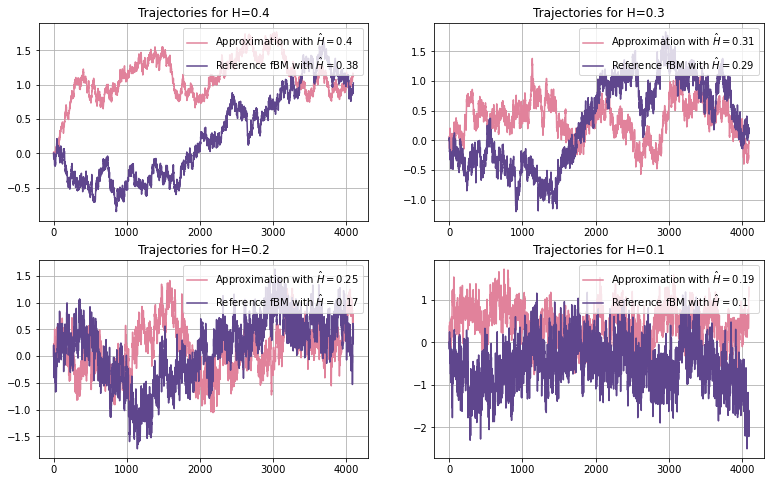

In [166]:
_, ax = plt.subplots(2, 2, figsize=(13, 8))

for num, hurst in enumerate(hursts):
    i, j = num // 2, num % 2
    muravlev_fbm_lif = fbm_muravlev(n=n, hurst=hurst, mode='lifted', n_beta=n_beta, extended_return=False)
    ref_fbm = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    
    label_mur = r"Approximation with $\hat H = $" + str(np.round(m_estimator(muravlev_fbm_lif), 2))
    label_ref = r"Reference fBM with $\hat H = $" + str(np.round(m_estimator(ref_fbm), 2))
    ax[i, j].plot(muravlev_fbm_lif, label=label_mur, c=col_approx)
    ax[i, j].plot(ref_fbm, label=label_ref, c=col_ref)
    ax[i, j].set_title(f"Trajectories for H={hurst}")
    ax[i, j].grid()
    ax[i, j].legend(bbox_to_anchor=(1, 1), loc="upper right")

In [165]:
importlib.reload(muravlev_approximation)
from muravlev_approximation import fbm_muravlev

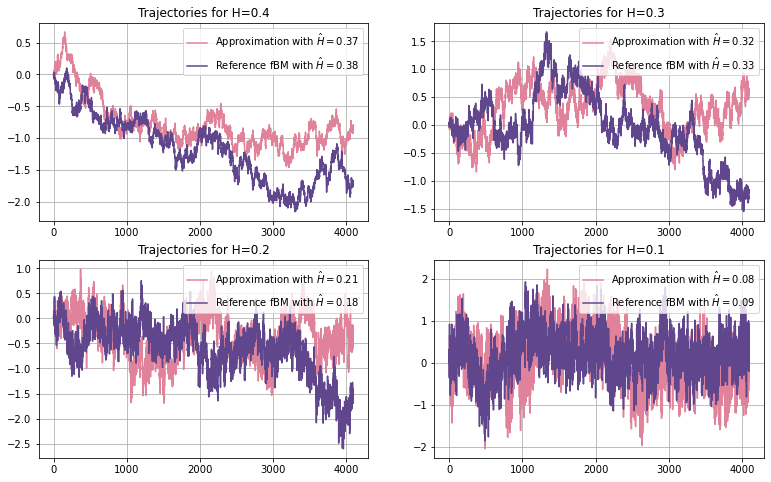

In [157]:
_, ax = plt.subplots(2, 2, figsize=(13, 8))

for num, hurst in enumerate(hursts):
    i, j = num // 2, num % 2
    muravlev_fbm = fbm_muravlev(n=n, hurst=hurst, mode='modified_lifted', n_beta=20, extended_return=False, r=2.75, k=0.45)
    ref_fbm = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    
    label_mur = r"Approximation with $\hat H = $" + str(np.round(m_estimator(muravlev_fbm), 2))
    label_ref = r"Reference fBM with $\hat H = $" + str(np.round(m_estimator(ref_fbm), 2))
    ax[i, j].plot(muravlev_fbm, label=label_mur, c=col_approx)
    ax[i, j].plot(ref_fbm, label=label_ref, c=col_ref)
    ax[i, j].set_title(f"Trajectories for H={hurst}")
    ax[i, j].grid()
    ax[i, j].legend(bbox_to_anchor=(1, 1), loc="upper right")

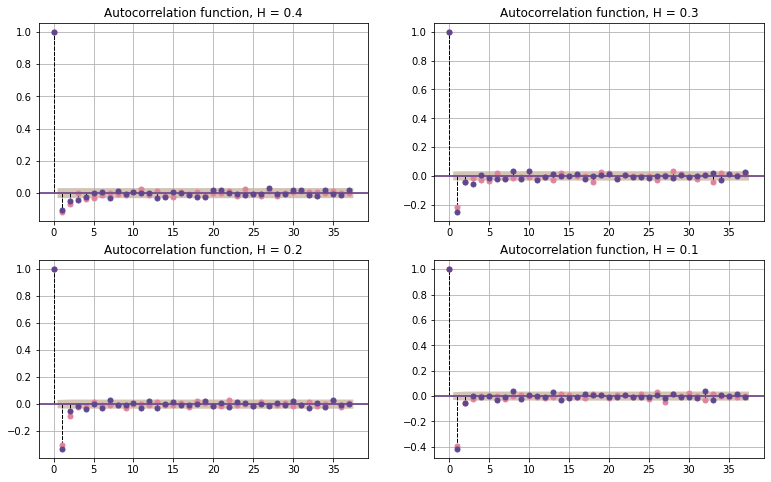

In [163]:
_, ax = plt.subplots(2, 2, figsize=(13, 8))

for num, hurst in enumerate(hursts):
    i, j = num // 2, num % 2
    muravlev_fbm = fbm_muravlev(n=n, hurst=hurst, mode='modified_lifted', n_beta=20, extended_return=False, r=2.75, k=0.45)
    ref_fbm = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    
    ax[i, j].grid()
    vlines_kwargs = {"color": "k", "linestyle": "--", "lw": 1}
    plot_acf(np.diff(muravlev_fbm), ax=ax[i, j], c=col_approx, vlines_kwargs=vlines_kwargs, title="")
    plot_acf(np.diff(ref_fbm), ax=ax[i, j], c=col_ref, vlines_kwargs=vlines_kwargs, title=f"Autocorrelation function, H = {hurst}")

In [144]:
method = 'lifted'

n_beta = 20
n_simulations = 500
H_estimations = dict()
H_estimations["ref"], H_estimations["mur"] = dict(), dict()
for num, hurst in enumerate(hursts):
    H_estimations["ref"][hurst] = list()
    H_estimations["mur"][hurst] = list()
    for i in tqdm(range(n_simulations)):
        muravlev_fbm = fbm_muravlev(n=n, hurst=hurst, mode=method, n_beta=n_beta, r=2.5)
        ref_fbm = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
        H_estimations["ref"][hurst].append(m_estimator(ref_fbm))
        H_estimations["mur"][hurst].append(m_estimator(muravlev_fbm))

100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


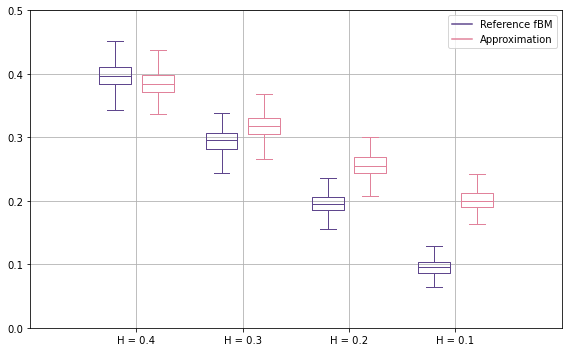

In [145]:
ticks = ["H = " + str(hurst) for hurst in hursts]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8, 5))

bp_ref = plt.boxplot(list(H_estimations["ref"].values()), positions=np.array(range(len(hursts)))*2.0-0.4, sym='', widths=0.6)
bp_mur = plt.boxplot(list(H_estimations["mur"].values()), positions=np.array(range(len(hursts)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bp_ref, col_ref) # colors are from http://colorbrewer2.org/
set_box_color(bp_mur, col_approx)

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=col_ref, label='Reference fBM')
plt.plot([], c=col_approx, label='Approximation')
plt.grid()
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 0.5)
plt.tight_layout()

# plt.title("Method = " + str(method) + "; n_beta = " + str(n_beta))
plt.show()

### How the process $Y_t^\alpha$ changes w.r.t $t$?

In [123]:
fig, ax = plt.subplots()
line, = ax.plot([], c='g')
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 2)
ax.set_xlabel(r"$\alpha$")
ax.set_title(r"Evolution of $(Y_t^\alpha)$ for $t > 0$")
ax.grid()

x = alphas

def animate(frame_num):
    y = Y[4*frame_num]
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=1000, interval=75)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  

### How the process $Y_t^\alpha$ changes w.r.t $\alpha$?

In [125]:
fig, ax = plt.subplots()
line, = ax.plot([], c='g')
ax.set_xlim(0, 1)
ax.set_ylim(-2, 2)
ax.set_xlabel(r"$t$")
ax.set_title(r"Evolution of $(Y_t^\alpha)$ for $-1 < \alpha < 1$")
ax.grid()

x = np.linspace(0, 1, n + 1)

def animate(frame_num):
    y = Y[:, frame_num]
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=n_beta, interval=50)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  